In [11]:
import matplotlib.pyplot as plt
from transmit import *
%matplotlib inline

## Setup OFDM system

In [12]:
# OFDM system setup:
test = OFDM
test.N, test.prefix_no, test.fs, test.repeat, test.gap_second = 2048, 256, 44100, 10, 1
test.__init__(test, test.N, test.prefix_no, test.fs, test.repeat, test.gap_second)

# File for transfer
filename = "test_files/shakespeare.txt"



In [13]:
# print the default seed for checking
test.seed

2021

## Generate Known OFDM symbols 

In [14]:
random_symbols = test.generate_random_symbols_seeds(test)
known_frame = symbol_to_OFDMframes(random_symbols, test.N, test.prefix_no)[0] # only 1 frame

In [15]:
chirp, inv_chirp = test.define_chirp(test)

## Generate transmitting signal with file 

788 352 377452 479
Total length of the signal is: 788


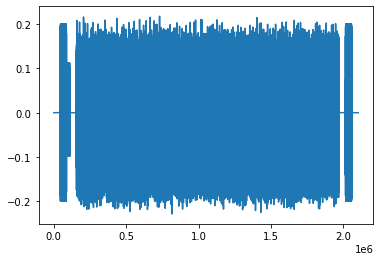

In [16]:
data_frames, carrier_indices, bits_tran = test.data_add_pilots(test, "test_files/shakespeare.txt")
print("Total length of the signal is:", len(data_frames))

known_frames = np.tile(known_frame, test.repeat)
gap = test.gap_second*test.fs
tx_signal = np.concatenate((np.zeros(gap), chirp, known_frames, np.zeros(gap), data_frames, np.zeros(gap), chirp, np.zeros(gap)), axis=None)
tx_signal = np.real(tx_signal)
plt.plot(tx_signal)
sf.write('transmit.wav', tx_signal, test.fs)

## Record and load the record file 

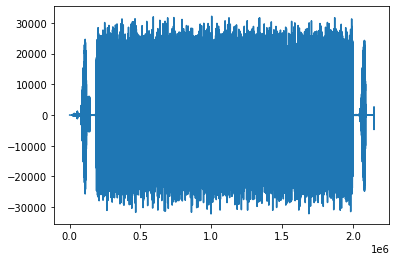

In [17]:
signal_out = test.real_channel_response_file(test, "sound_files/rec7.m4a")
plt.plot(signal_out)

## Use matched filter to determine the chirp location

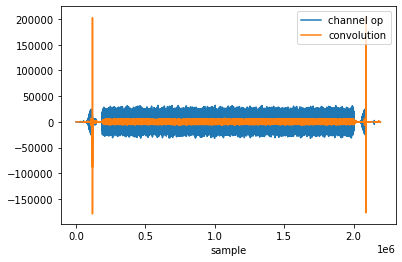

In [18]:
convolution, peak_index1, peak_index2 = test.matched_filter_double(test, signal_out, inv_chirp)
plt.plot()
plt.plot(signal_out, label='channel op')
plt.plot(convolution/100, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')


In [20]:
# Assign the channel convolution output for detection TODO
#channel_dect = convolution[0:250000]
start = test.find_start(test, peak_index1)
print(start)

162508


In [21]:
split_frame, avg_frame, start_refined = test.process_transmission_pilot(test, signal_out, peak_index1, offset=20)

## Measure the channel response:

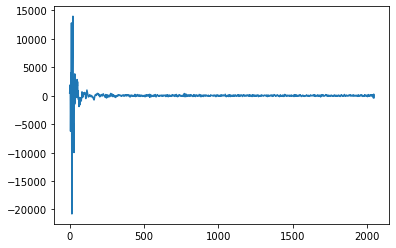

In [19]:
channel_freq_response, channel_imp_response = test.estimate_channel_response_pilot(test, avg_frame, known_frames)
plt.plot(channel_imp_response)

## Retrieve the transmitted informations

1. Manually select the offset 

In [11]:
error, score = test.sync_error(test, signal_out, start, 20, bits_tran,Known_frames, fileout=False)
print(error, score)

0.23224476266242375 9.472508549689074


2. automatically select the offset

In [12]:
best_offset, score, bits_rec, best_imp_response = test.fine_tune(test, signal_out, start, Known_frames, find_range=20, offset=20)
print(best_offset, score)
# Check the error rate, if it decrease on the manually selected 20 
print(error_rate(bits_tran,bits_rec))

19 9.484477583115975
0.23096260938743038


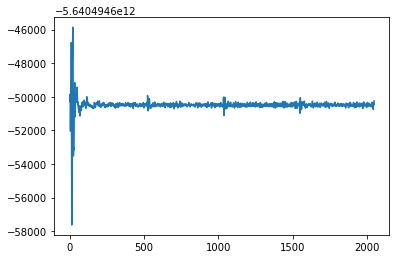

In [13]:
# print the best impulse response
plt.plot(best_imp_response)

# Part II With pilot symbols for phase correction 